## Решение задачи:

Выполним установку необходимых библиотек:

In [ ]:
# Устанавливаем SWIG отдельно, чтобы убедиться, что он доступен
!pip install swig

# Устанавливаем gymnasium вместе с зависимостью box2d и matplotlib
!pip install gymnasium[box2d] matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409504 sha256=d38478699b2383da1d17d45fac86729d4efc18766bc6fec929c6fefe5b8224ff
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


Импорт необходимых библиотек:

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Функциональный API torch (например, функции потерь)
from torch.distributions import Normal  # Для PPO: создание нормального распределения для выбора действий
import copy
import random
from collections import deque  # Двусторонняя очередь для реализации буфера воспроизведения
import os
import matplotlib.pyplot as plt

Класс `ReplayBuffer` служит для хранения "опыта" агента, то есть последовательностей (состояние, действие, награда, новое состояние, завершён ли эпизод). Это нужно, чтобы агент мог обучаться на разных примерах из прошлого, а не только на последнем эпизоде. Буфер ограничен по размеру, чтобы не занимать всю оперативную память, старые записи автоматически удаляются:

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        # Инициализация буфера с максимальной вместимостью (capacity)
        # deque(maxlen=...) автоматически удаляет старые элементы при добавлении новых
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    # Добавление нового перехода (опыта) в буфер
    def push(self, state, action, reward, next_state, done):
        # Мы сохраняем опыт в виде кортежа
        self.buffer.append((state, action, reward, next_state, done))

    # Извлечение случайной выборки (батча) из буфера
    def sample(self, batch_size):
        # random.sample выбирает batch_size уникальных элементов из буфера
        batch = random.sample(self.buffer, batch_size)

        # zip(*batch) "разворачивает" список кортежей в отдельные кортежи
        # (s1, a1, r1), (s2, a2, r2) -> (s1, s2), (a1, a2), (r1, r2)
        state, action, reward, next_state, done = zip(*batch)

        # Преобразуем списки в массивы numpy для удобной подачи в нейронную сеть
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )

    # Возвращает текущий размер буфера
    def __len__(self):
        return len(self.buffer)

`ActorDDPG` — это класс нейронной сети, которая учится выбирать наилучшее действие для текущего состояния среды. Сеть принимает состояние на вход и выдаёт действие, масштабируя его к допустимому диапазону среды. Этот класс используется для создания "мозга" агента `DDPG`, определяющего его поведение.

`CriticDDPG` — это класс нейронной сети, которая учится оценивать, насколько хороша пара состояние-действие (*Q-функция*). Критик помогает актёру учиться, говоря, как хорошо то или иное действие в каждом состоянии. Сеть принимает на вход как состояние, так и действие, и выдаёт одно число — оценку.

In [ ]:
class ActorDDPG(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        # max_action - это максимальное значение действия в среде (например, 1.0 или 2.0)
        self.max_action = max_action

        # Определяем архитектуру сети
        self.net = nn.Sequential(
            nn.Linear(state_dim, 400),  # Входной слой: размер состояния -> 400 нейронов
            nn.ReLU(),  # Функция активации
            nn.Linear(400, 300),  # Скрытый слой
            nn.ReLU(),
            nn.Linear(300, action_dim),  # Выходной слой: 300 -> размер действия
            nn.Tanh()  # Гиперболический тангенс. Выдает значения в диапазоне [-1, 1]
        )

    def forward(self, state):
        # Прямой проход: пропускаем состояние через сеть
        # Масштабируем выход Tanh [-1, 1] до диапазона действий среды [-max_action, max_action]
        return self.max_action * self.net(state)

class CriticDDPG(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        # Архитектура сети критика
        # Важно: на вход критик получает и СОСТОЯНИЕ, и ДЕЙСТВИЕ
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 400),  # Входной слой (состояние + действие)
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 1)  # Выходной слой: 1 нейрон (предсказание Q-value)
        )

    def forward(self, state, action):
        # Прямой проход:
        # Объединяем (конкатенируем) тензоры состояния и действия по оси 1
        return self.net(torch.cat([state, action], dim=1))

`DDPGAgent` — это основной класс, который объединяет актёра, критика, буфер опыта и всю логику обучения агента `DDPG`. В конструкторе создаются все необходимые компоненты и задаются параметры обучения. Внутри есть методы для выбора действия (`select_action`), обучения (`train`), и сохранения модели (`save_checkpoint`). Этот агент учится с помощью опыта, накопленного в буфере, и обновляет свои нейронные сети для более успешного управления средой.

In [ ]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, device, buffer_size=500000):
        self.device = device  # Устройство (CPU или CUDA)
        self.logdir = 'runs/DDPG_checkpoints'  # Папка для сохранения моделей
        os.makedirs(self.logdir, exist_ok=True) # Создаем папку, если ее нет

        # Основной Актёр
        self.actor = ActorDDPG(state_dim, action_dim, max_action).to(self.device)
        # Целевой Актёр - используется для стабильного расчета целевых Q-значений
        self.actor_target = copy.deepcopy(self.actor).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4) # Оптимизатор для актёра

        # Основной Критик
        self.critic = CriticDDPG(state_dim, action_dim).to(self.device)
        # Целевой Критик
        self.critic_target = copy.deepcopy(self.critic).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3) # Оптимизатор для критика

        # Буфер для хранения опыта
        self.memory = ReplayBuffer(buffer_size)

        self.batch_size = 128  # Размер выборки из буфера для одного шага обучения
        self.gamma = 0.99  # Коэффициент дисконтирования (насколько важны будущие награды)
        self.tau = 0.005  # Коэффициент "мягкого" обновления целевых сетей

    def select_action(self, state):
        # Выбор действия (используется для взаимодействия со средой)
        #Переводим состояние (numpy array) в тензор PyTorch
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Переводим актёра в режим оценки
        self.actor.eval()

        # Отключаем расчет градиентов (для ускорения)
        with torch.no_grad():
            # Получаем действие от актёра
            action = self.actor(state).cpu().numpy().flatten()

        # Возвращаем актёра в режим обучения
        self.actor.train()

        return action

    def train(self):
        # Функция обучения агента (вызывается на каждом шаге)

        # Проверяем, достаточно ли опыта в буфере для обучения
        if len(self.memory) < self.batch_size:
            return  # Если мало, выходим

        # Сэмплируем батч из буфера
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)

        # Конвертируем numpy массивы в тензоры PyTorch и отправляем на device
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)

        with torch.no_grad(): # Не считаем градиенты для целевых сетей
            # Получаем следующее действие от *целевого* актёра
            next_action = self.actor_target(next_state)

            # Рассчитываем целевое Q-значение
            target_Q = self.critic_target(next_state, next_action)
            target_Q = reward + (1 - done) * self.gamma * target_Q

        # Получаем текущее Q-значение от *основного* критика
        current_Q = self.critic(state, action)

        # Считаем ошибку (Loss) как среднеквадратичную ошибку (MSE) между целевым и текущим Q
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Обновляем веса критика
        self.critic_optimizer.zero_grad()  # Обнуляем градиенты
        critic_loss.backward()  # Считаем градиенты
        self.critic_optimizer.step()  # Делаем шаг оптимизации

        # Считаем Loss для актёра
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Обновляем веса актёра
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Мягкое обновление целевых сетей

        # Обновление целевого критика
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Обновление целевого актёра
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save_checkpoint(self, episode):
        # Сохраняем веса (state_dict) нейронных сетей в файл
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
        }, os.path.join(self.logdir, f'checkpoint_{episode}.pth'))

Класс `ActorCritic` реализует нейронную сеть, объединяющую две роли: актёра (который выбирает действия) и критика (который оценивает состояния). Он используется в алгоритме `PPO` для более стабильного обучения. Отдельные блоки **actor** и **critic** позволяют одновременно предсказывать оптимальное действие и оценку состояния.

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super().__init__()

        # Актёр (политика)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, action_dim), nn.Tanh() # Выход - среднее (mean) для распределения
        )

        # Критик (оценка ценности состояния)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1) # Выход - одно число
        )

        # Агенту PPO нужно иногда "ошибаться" и пробовать новые действия (это называется "исследование").
        # Для этого он выбирает действие не точно, а с небольшой долей случайности.
        #
        # Эта переменная (action_var) как раз и задает "степень" этой случайности (насколько
        # сильно действия могут отклоняться от "лучшего" варианта).
        #
        # В этой реализации мы *не обучаем* этот параметр (requires_grad=False),
        # а просто задаем его один раз при создании агента. Он всегда будет одинаковым.
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std ** 2), requires_grad=False)

    def forward(self):
        # ЭТА ФУНКЦИЯ СПЕЦИАЛЬНО ВЫЗОВЕТ ОШИБКУ
        #
        # Наш класс ActorCritic — это просто "коробка" для двух сетей:
        # 1. self.actor (выдает действие)
        # 2. self.critic (выдает оценку)
        #
        # Мы никогда не вызываем их "вместе", а всегда обращаемся
        # к ним по отдельности (например, policy.actor(state)).
        #
        # Эта заглушка нужна, чтобы код сломался, если кто-то
        # по ошибке попытается вызвать всю "коробку" целиком (например, policy(state)).
        raise NotImplementedError

`PPOAgent` — это класс для агента, обучающегося по алгоритму **Proximal Policy Optimization (PPO)**. Этот агент хранит политику (нейросеть), буфер опыта, параметры обучения и логику обновления своей политики. Внутри реализованы методы для выбора действия (`select_action`), обновления политики (`update`), оценки действий (`evaluate`) и сохранения модели (`save_checkpoint`). `PPOAgent` учится на целых эпизодах, обновляя свою стратегию на основании собранных данных.

In [ ]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, device, lr_actor=3e-4, lr_critic=1e-3, gamma=0.99, K_epochs=40, eps_clip=0.2, action_std_init=0.6):
        self.device = device
        self.gamma = gamma  # Коэффициент дисконтирования
        self.eps_clip = eps_clip  # Параметр "клиппинга" PPO (насколько сильно может меняться политика)
        self.K_epochs = K_epochs  # Количество эпох обучения на *одном* батче данных
        self.logdir = 'runs/PPO_checkpoints'  # Папка для сохранения моделей
        os.makedirs(self.logdir, exist_ok=True) # Создаем папку

        # Основная политика (которую мы обучаем)
        self.policy = ActorCritic(state_dim, action_dim, action_std_init).to(device)

        # "Старая" политика (которая собирала данные)
        # Мы храним ее веса, чтобы считать "соотношение" новой и старой политики
        self.policy_old = copy.deepcopy(self.policy).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict()) # Убедимся, что веса идентичны

        # Оптимизатор для обеих частей сети (актёра и критика)
        self.optimizer = optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])

        # Функция потерь для критика (MSE)
        self.MseLoss = nn.MSELoss()

        # Временное хранилище (память) для сбора одного эпизода/батча
        self.memory = []

    def select_action(self, state):
        # Выбор действия (для сбора данных)
        # Используем "старую" политику
        state = torch.FloatTensor(state).to(self.device)

        with torch.no_grad():
            # Получаем "среднее" (mean) действия от актёра
            action_mean = self.policy_old.actor(state)

            # Создаем нормальное распределение с этим средним и сохраненной дисперсией
            dist = Normal(action_mean, self.policy_old.action_var.sqrt())

            # Сэмплируем (выбираем) стохастическое действие из распределения
            action = dist.sample()

            # Считаем логарифм вероятности этого действия
            action_logprob = dist.log_prob(action)

        # Сохраняем переход во временную память
        # (Награду и 'done' мы добавим позже, после шага в среде)
        self.memory.append({'state': state, 'action': action, 'log_prob': action_logprob, 'reward': None, 'done': None})

        # Ограничиваем действие диапазоном [-1, 1] и возвращаем
        return action.clamp(-1.0, 1.0).cpu().numpy()

    def update(self):
        rewards = []
        discounted_reward = 0

        # Идем по собранному эпизоду *в обратном порядке*
        for i in reversed(range(len(self.memory))):
            reward = self.memory[i]['reward']
            done = self.memory[i]['done']

            if done:
                discounted_reward = 0  # Если эпизод окончен, будущая награда = 0

            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward) # Добавляем discounted_reward в начало списка

        # Это стабилизирует обучение (уменьшает дисперсию градиентов)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Сбор данных из памяти (старые состояния, действия, log_probs)
        old_states = torch.stack([m['state'] for m in self.memory]).detach().to(self.device)
        old_actions = torch.stack([m['action'] for m in self.memory]).detach().to(self.device)
        old_logprobs = torch.stack([m['log_prob'] for m in self.memory]).detach().to(self.device)

        # Мы многократно (K_epochs) обучаемся на *одном и том же* батче данных
        for _ in range(self.K_epochs):

            # Оцениваем старые состояния/действия с помощью *новой* (обучаемой) политики
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)

            # Рассчитываем преимущество
            advantages = rewards - state_values.detach()

            # Считаем соотношение вероятностей
            ratios = torch.exp(logprobs - old_logprobs.sum(-1, keepdim=True).squeeze())

            # Считаем PPO Loss (Clipped Objective)
            # Loss Актёра:
            surr1 = ratios * advantages  # Обычный Policy Gradient
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages # "Обрезанный" Policy Gradient

            # Мы берем минимум из двух (это и есть "клиппинг" PPO)
            # и берем минус, т.к. мы хотим максимизировать (а pytorch минимизирует)
            actor_loss = -torch.min(surr1, surr2)

            # Loss Критика
            critic_loss = 0.5 * self.MseLoss(state_values, rewards)

            # Энтропия (для поощрения исследования)
            entropy_loss = -0.01 * dist_entropy

            # Суммарный Loss
            loss = actor_loss + critic_loss + entropy_loss

            # Обновление весов
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # После K эпох обучения, мы копируем веса из self.policy в self.policy_old
        self.policy_old.load_state_dict(self.policy.state_dict())

        # PPO - on-policy, поэтому старые данные больше не нужны
        self.memory = []

    def evaluate(self, state, action):
        # Эта функция вызывается во время "обновления" (обучения) агента.
        # Ее задача — взять *старые* состояния (state) и *старые* действия (action),
        # которые мы собрали, и "пере-оценить" их с точки зрения *новой*,
        # только что обновленной, политики (self.policy).
        #
        # Это нужно, чтобы сравнить, "стало ли лучше?" (насколько новая
        # политика отличается от старой).

        # Получаем среднее от актёра
        action_mean = self.policy.actor(state)

        # Создаем распределение
        dist = Normal(action_mean, self.policy.action_var.sqrt())

        # Считаем логарифм вероятности
        action_logprobs = dist.log_prob(action)

        # Считаем энтропию (для exploration bonus)
        dist_entropy = dist.entropy().mean(1)

        # Получаем оценку ценности состояния от критика
        state_values = self.policy.critic(state).squeeze()

        return action_logprobs.sum(-1, keepdim=True), state_values, dist_entropy.mean()

    def save_checkpoint(self, episode):
        # Сохраняем веса (state_dict) нейронных сетей в файл
        torch.save({
            'actor': self.policy.actor.state_dict(),
            'critic': self.policy.critic.state_dict(),
        }, os.path.join(self.logdir, f'checkpoint_{episode}.pth'))

Для ясности выведем параметры нашей среды:

In [ ]:
print("--- Параметры среды BipedalWalker-v3 ---")
env_for_params = gym.make('BipedalWalker-v3')
state_dim = env_for_params.observation_space.shape[0]
print(f"Размерность состояния: {state_dim}")
action_dim = env_for_params.action_space.shape[0]
print(f"Размерность действия: {action_dim}")
max_action = float(env_for_params.action_space.high[0])
env_for_params.close()

--- Параметры среды BipedalWalker-v3 ---
Размерность состояния: 24
Размерность действия: 4


Глобальные параметры:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Выбираем устройство (GPU, если доступно, иначе CPU)
num_episodes = 1000

Этот блок отвечает за весь цикл обучения агента `DDPG`. Здесь происходит инициализация среды, создание агентов, запуск эпизодов, сбор наград и обучение агентов. Для каждого алгоритма выводится прогресс обучения, а также сохраняются модели и логируются результаты для последующего анализа.

In [ ]:
print("\nНачинаем обучение DDPG...")
env_ddpg = gym.make('BipedalWalker-v3')
agent_ddpg = DDPGAgent(state_dim, action_dim, max_action, device)
rewards_ddpg = [] # Список для хранения наград по эпизодам

for episode in range(num_episodes):
    state, _ = env_ddpg.reset() # Сброс среды
    episode_reward = 0
    done = False
    step_count = 0

    # Цикл одного эпизода (пока агент не упадет или не дойдет до конца)
    while not done:
        # Агент выбирает действие
        action = agent_ddpg.select_action(state)

        # Добавляем шум к действию для исследования (Exploration)
        # DDPG - детерминированный, без шума он будет всегда выбирать одно и то же
        noise = np.random.normal(0, max_action * 0.1, size=action_dim)
        action = (action + noise).clip(env_ddpg.action_space.low, env_ddpg.action_space.high)

        # Совершаем шаг в среде
        next_state, reward, terminated, truncated, _ = env_ddpg.step(action)
        done = terminated or truncated

        # Сохраняем переход в буфер
        agent_ddpg.memory.push(state, action, reward, next_state, float(done))

        # Обучаем агента (DDPG обучается на *каждом* шаге)
        agent_ddpg.train()

        # Обновляем состояние и награду
        state = next_state
        episode_reward += reward
        step_count += 1

    rewards_ddpg.append(episode_reward)

    # Вывод прогресса
    if episode % 20 == 0:
        print(f"DDPG | Эпизод {episode}, Награда: {episode_reward:.2f}")

    # Сохранение контрольной точки
    if episode % 100 == 0 and episode > 0:
        agent_ddpg.save_checkpoint(episode)

    # Очистка кеша CUDA (иногда помогает избежать нехватки памяти)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

avg_reward_ddpg = np.mean(rewards_ddpg[-100:])
print(f"\nСредняя награда DDPG за последние 100 эпизодов: {avg_reward_ddpg:.2f}")
env_ddpg.close()


Начинаем обучение DDPG...
DDPG | Эпизод 0, Награда: -112.03
DDPG | Эпизод 20, Награда: -111.71
DDPG | Эпизод 40, Награда: -117.55
DDPG | Эпизод 60, Награда: -107.88
DDPG | Эпизод 80, Награда: -111.15
DDPG | Эпизод 100, Награда: -106.57
DDPG | Эпизод 120, Награда: -154.97
DDPG | Эпизод 140, Награда: -115.97
DDPG | Эпизод 160, Награда: -136.77
DDPG | Эпизод 180, Награда: -116.83
DDPG | Эпизод 200, Награда: -118.49
DDPG | Эпизод 220, Награда: -121.04
DDPG | Эпизод 240, Награда: -114.58
DDPG | Эпизод 260, Награда: -113.77
DDPG | Эпизод 280, Награда: -122.46
DDPG | Эпизод 300, Награда: -155.38
DDPG | Эпизод 320, Награда: -218.00
DDPG | Эпизод 340, Награда: -204.98
DDPG | Эпизод 360, Награда: -132.51
DDPG | Эпизод 380, Награда: -126.97
DDPG | Эпизод 400, Награда: -120.48
DDPG | Эпизод 420, Награда: -119.81
DDPG | Эпизод 440, Награда: -141.91
DDPG | Эпизод 460, Награда: -155.00
DDPG | Эпизод 480, Награда: -236.41
DDPG | Эпизод 500, Награда: -92.08
DDPG | Эпизод 520, Награда: -128.08
DDPG | Э

Этот блок отвечает за весь цикл обучения агента `PPO`. Здесь происходит инициализация среды, создание агентов, запуск эпизодов, сбор наград и обучение агентов. Для каждого алгоритма выводится прогресс обучения, а также сохраняются модели и логируются результаты для последующего анализа.

In [ ]:
print("\nНачинаем обучение PPO...")
env_ppo = gym.make('BipedalWalker-v3')
agent_ppo = PPOAgent(state_dim, action_dim, device)
rewards_ppo = [] # Список для хранения наград по эпизодам

for episode in range(num_episodes):
    state, _ = env_ppo.reset() # Сброс среды
    episode_reward = 0
    done = False

    # Цикл сбора данных для одного эпизода (или до max шагов)
    for t in range(1600): # 1600 - лимит шагов в BipedalWalker

        # Агент выбирает стохастическое действие
        action = agent_ppo.select_action(state)

        # Совершаем шаг в среде
        next_state, reward, terminated, truncated, _ = env_ppo.step(action)
        done = terminated or truncated

        # Записываем награду и 'done' в *последний* элемент памяти
        # (который был создан в select_action)
        agent_ppo.memory[-1]['reward'] = reward
        agent_ppo.memory[-1]['done'] = done

        # Обновляем состояние и награду
        state = next_state
        episode_reward += reward

        if done:
            break # Если эпизод закончился, прекращаем сбор данных

    # Обучаем агента на всех шагах этого эпизода (PPO учится после завершения эпизода)
    agent_ppo.update()

    rewards_ppo.append(episode_reward)

    # Вывод прогресса
    if episode % 20 == 0:
        print(f"PPO | Эпизод {episode}, Награда: {episode_reward:.2f}")

    # Сохранение контрольной точки
    if episode % 100 == 0 and episode > 0:
        agent_ppo.save_checkpoint(episode)

    # Очистка кеша CUDA
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

avg_reward_ppo = np.mean(rewards_ppo[-100:])
print(f"\nСредняя награда PPO за последние 100 эпизодов: {avg_reward_ppo:.2f}")
env_ppo.close()


Начинаем обучение PPO...
PPO | Эпизод 0, Награда: -80.36
PPO | Эпизод 20, Награда: -101.37
PPO | Эпизод 40, Награда: -104.69
PPO | Эпизод 60, Награда: -103.20
PPO | Эпизод 80, Награда: -102.25
PPO | Эпизод 100, Награда: -103.74
PPO | Эпизод 120, Награда: -98.94
PPO | Эпизод 140, Награда: -123.38
PPO | Эпизод 160, Награда: -124.91
PPO | Эпизод 180, Награда: -139.34
PPO | Эпизод 200, Награда: -107.30
PPO | Эпизод 220, Награда: -104.35
PPO | Эпизод 240, Награда: -105.25
PPO | Эпизод 260, Награда: -124.99
PPO | Эпизод 280, Награда: -114.00
PPO | Эпизод 300, Награда: -106.58
PPO | Эпизод 320, Награда: -106.84
PPO | Эпизод 340, Награда: -117.33
PPO | Эпизод 360, Награда: -116.49
PPO | Эпизод 380, Награда: -125.57
PPO | Эпизод 400, Награда: -140.94
PPO | Эпизод 420, Награда: -119.25
PPO | Эпизод 440, Награда: -150.26
PPO | Эпизод 460, Награда: -119.26
PPO | Эпизод 480, Награда: -111.39
PPO | Эпизод 500, Награда: -116.49
PPO | Эпизод 520, Награда: -143.56
PPO | Эпизод 540, Награда: -122.59
PP

Функция `plot_rewards` строит график наград для обоих агентов, чтобы визуально сравнить, кто из них обучился лучше. Она отображает как реальные награды за каждый эпизод, так и скользящее среднее, чтобы было видно тренд. График помогает понять, как быстро и насколько хорошо агенты учатся.

In [ ]:
def plot_rewards(rewards_ddpg, rewards_ppo):
    plt.figure(figsize=(12, 6))
    plt.title('Сравнение производительности DDPG и PPO на BipedalWalker-v3')
    plt.xlabel('Эпизод')
    plt.ylabel('Награда за эпизод')

    # График DDPG
    # Рисуем награды за каждый эпизод (полупрозрачный)
    plt.plot(rewards_ddpg, label='Награда DDPG (за эпизод)', color='lightcoral', alpha=0.6)
    # Считаем скользящее среднее для 50 эпизодов
    # 'valid' означает, что результат будет короче исходного массива
    ddpg_moving_avg = np.convolve(rewards_ddpg, np.ones(50)/50, mode='valid')
    # Рисуем скользящее среднее (жирная линия)
    plt.plot(np.arange(49, len(rewards_ddpg)), ddpg_moving_avg, label='Скользящее среднее DDPG (50 эп.)', color='red', linewidth=2)

    # График PPO
    # Аналогично для PPO
    plt.plot(rewards_ppo, label='Награда PPO (за эпизод)', color='lightblue', alpha=0.6)
    ppo_moving_avg = np.convolve(rewards_ppo, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(49, len(rewards_ppo)), ppo_moving_avg, label='Скользящее среднее PPO (50 эп.)', color='blue', linewidth=2)

    plt.legend() # Показать легенду
    plt.grid(True) # Включить сетку
    plt.show() # Показать график

Воспользуемся функцией создания графика:

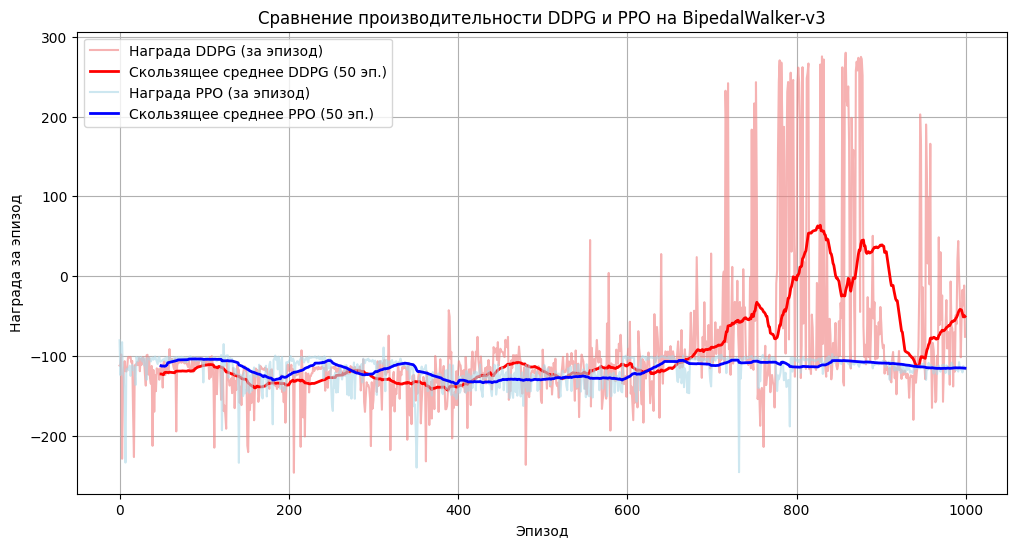

In [ ]:
plot_rewards(rewards_ddpg, rewards_ppo)

## Анализ полученных результатов:

`DDPG` показал значительный прогресс в обучении, начиная с отрицательных наград, постепенно достигая положительных значений (>200) в некоторых эпизодах. Наблюдается тренд вверх. При увеличении количества эпизодов данный подход мог бы показать более позитивные результаты.

`PPO` остался на уровне отрицательных наград и не продемонстрировал явного улучшения. Судя по графику, тренд отсутствует и при увеличении количества эпизодов вряд ли будет демонстрироваться явный прогресс.

**Вывод**:


---


DDPG лучше подходит для данной среды, быстрее учится ходить и достигает лучших результатов.


**Рекомендации по улучшению модели**:

---



для `PPO` стоит поэкспериментировать с гиперпараметрами (уменьшить `K_epochs`, увеличить `std` действий, попробовать другой `scheduler` для `lr`)

для `DDPG` можно уменьшать шум по мере обучения, добавить `early stopping`.